# Compare the amplitudes from all of the vkdv scenarios

| Test No. | Name | Density Model | a0 Model     |
| -------- | ------------------ | ------------- | ------------ |
| 1        |  harmo_a0_data_rho   | in situ       | harmonics    |
| 2        |  stoch_a0_data_rho | in situ       | harmonics+AR |
| 3        |  harmo_a0_clim_rho | seasonal      | harmonics    |
| 4        |  stoch_a0_clim_rho | seasonal      | harmonics+AR |

In [1]:
!ls -lah ../outputs/*v3*.nc

-rwxrwxrwx 1 root root 24M Apr  8 12:49 ../outputs/2021-04-08--01-28-36_slim-harmo_a0_clim_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M Apr  8 12:49 ../outputs/2021-04-08--01-29-08_slim-harmo_a0_clim_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M Apr  8 12:49 ../outputs/2021-04-08--01-30-37_slim-harmo_a0_data_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M Apr  8 12:49 ../outputs/2021-04-08--01-31-31_slim-stoch_a0_clim_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M Apr  8 12:49 ../outputs/2021-04-08--01-34-42_slim-stoch_a0_data_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M May 11 21:09 ../outputs/2021-05-11--12-50-26_slim-seasonal_a0_data_rho_v3_magnus_kdv_runs.nc
-rwxrwxrwx 1 root root 24M May 11 21:09 ../outputs/2021-05-11--12-51-40_slim-seasonal_a0_clim_rho_v3_magnus_kdv_runs.nc


In [4]:
# vkdvfile = '../output/2021-04-07--05-27-46_slim-harmo_a0_clim_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_clim_rho_v2'

# vkdvfile = '../output/2021-04-07--05-26-47_slim-harmo_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_data_rho'

# vkdvfile = '../outputs/2021-04-08--01-31-31_slim-stoch_a0_clim_rho_v3_magnus_kdv_runs.nc'
# sitename = 'stoch_a0_clim_rho'

# vkdvfile = '../output/2021-04-06--23-57-18_slim-stoch_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'stoch_a0_data_rho'

vkdvfiles = {
    'harmo_a0_data_rho':'../outputs/2021-04-08--01-30-37_slim-harmo_a0_data_rho_v3_magnus_kdv_runs.nc',
    'harmo_a0_clim_rho':'../outputs/2021-04-08--01-29-08_slim-harmo_a0_clim_rho_v3_magnus_kdv_runs.nc',
    'stoch_a0_clim_rho':'../outputs/2021-04-08--01-31-31_slim-stoch_a0_clim_rho_v3_magnus_kdv_runs.nc',
    'stoch_a0_data_rho':'../outputs/2021-04-08--01-34-42_slim-stoch_a0_data_rho_v3_magnus_kdv_runs.nc',
    'seasonal_a0_clim_rho':'../outputs/2021-05-11--12-51-40_slim-seasonal_a0_clim_rho_v3_magnus_kdv_runs.nc',
    'seasonal_a0_data_rho':'../outputs/2021-05-11--12-50-26_slim-seasonal_a0_data_rho_v3_magnus_kdv_runs.nc',   
}



In [5]:
from sfoda.utils.othertime import SecondsSince

from datetime import datetime
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py
# import seaborn as sns

import matplotlib.dates as mdates

In [6]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'medium'

In [7]:
def min_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [8]:
# Validate the amplitude also...
###########
#basedir = 'C:\Projects\ARCHub\DATA\FIELD\ShellCrux\'

# basedir = '/home/mrayson/group/mrayson/DATA/FIELD/ShellCrux/'
#ncfile = '/home/suntans/Projects/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
basedir = '/home/suntans/cloudstor/Data/Crux/'
ncfile = '{}/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'.format(basedir)
freq = '24H'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan

time1 = pd.date_range('2016-5-1','2016-9-15',freq=freq) 
time2 = pd.date_range('2016-11-1','2017-5-1',freq=freq)
timemax = time1.append(time2)

Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    #Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)

    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))


In [9]:
def load_vkdv(vkdvfile):
    dskdv = xr.open_dataset(vkdvfile)
    idx = dskdv.time > np.datetime64('2030-01-01')
    ds = dskdv.isel({'time':~idx})
    return ds

In [12]:
# Calculate the probability
def calc_Aprob(ds):
    Abins = np.arange(0,85,2.5)
    na = Abins.shape[0]
    nt = ds.time.shape[0]
    nsamples = ds.ensemble.shape[0]
    Aprob = np.zeros((na, nt))
    for ii,aa in enumerate(Abins):
        idx_kdv  = np.abs(ds.amax.values) > aa
        plarge = idx_kdv.sum(axis=0)/nsamples * 100

        Aprob[ii,:] = plarge

    time=ds.time.values
    return Aprob, Abins, time

def plot_vkdv_prob(vkdvfile):
    Aprob, Abins, time = calc_Aprob(load_vkdv(vkdvfile))
    
    plt.contourf(time, Abins, Aprob, [1,5,25,50,75,95,99],  cmap='inferno', extend='max')
    plt.plot(ds_A['time'], np.abs(ds_A.values),'x',color='r', ms=2, alpha=0.9)
    plt.xlim(time[0],time[-1])
    plt.ylabel('$|A|$ [m]')
    plt.colorbar()
    plt.grid(b=True,ls=':')

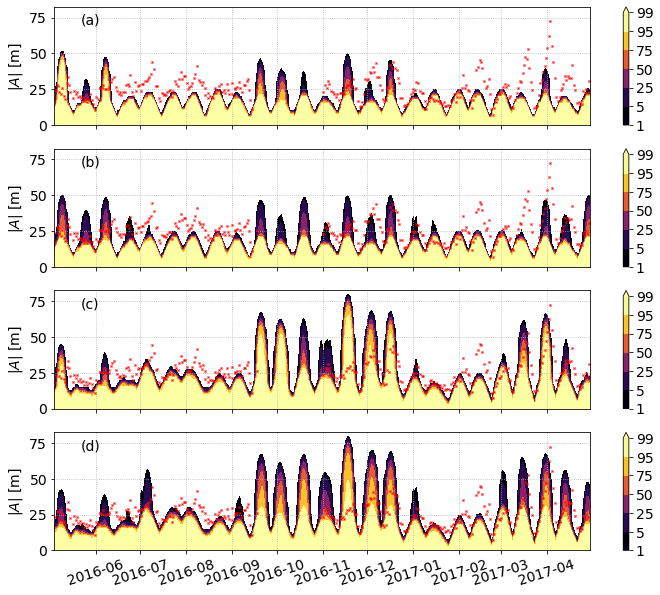

In [14]:
plt.figure(figsize=(12,10))
#plt.pcolormesh(ds.time.values, Abins, Aprob)
# plt.contourf(ds.time.values, Abins, Aprob, [1,5,25,50,75,95,99], cmap='gray_r', extend='min')
ax = plt.subplot(411)
plot_vkdv_prob(vkdvfiles['harmo_a0_data_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(a)',transform=ax.transAxes)
ax = plt.subplot(412)
plot_vkdv_prob(vkdvfiles['harmo_a0_clim_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(b)',transform=ax.transAxes)

ax = plt.subplot(413)
plot_vkdv_prob(vkdvfiles['seasonal_a0_data_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(c)',transform=ax.transAxes)

ax = plt.subplot(414)
plot_vkdv_prob(vkdvfiles['seasonal_a0_clim_rho'])
plt.xticks(rotation=17)
plt.text(0.05,0.85,'(d)',transform=ax.transAxes)

plt.savefig('../FIGURES/vkdv_Aprob_v2.png', dpi=150)
plt.savefig('../FIGURES/vkdv_Aprob_v2.pdf', dpi=150)

In [41]:
Aprob.shape

(26, 367)